# SARIMAX
_**Author**: Mahdi S. (DSI-NYC)_ 
***

## Table of Contents
1. [The 4 parts of time series](#The-4-parts-of-time-series)
1. [SARIMA Workflow](#SARIMA-Workflow)
    1. [Format time-series](#Australian-Tourism-Dataset)
    1. [Visualize data](#Visualizing-data-(abridged-to-save-time))
    1. [Determine Seasonality $S$](#Determining-Seasonality)
        1. [Additive vs. Multiplicative Seasonality](#Additive-vs.-Multiplicative-Seasonality)
        1. [Decomposing the data](#Decomposing-the-data)
    1. [Ensure Stationarity (determine $d$ and $D$)](#Determine-$d$-and-$D$)
    1. [Determine $p$ and $q$ and $P$ and $Q$](#Determine-$p$-and-$q$-and-$P$-and-$Q$)
        1. [Using `auto_arima`](#Using-auto_arima)
        1. [Using a custom time series grid search](#Using-a-custom-time-series-grid-search)
    1. [Build model](#Modeling)
    1. [Visualize model predictions](#Visualizing-Predictions)
        1. [Using `.forecast`](#Using-.forecast)
        1. [Using `.predict`](#Using-.predict)
        1. [Using `.fittedvalues`](#Using-.fittedvalues)
        1. [Using `.get_forecast` and `.get_prediction`](#Using-.get_forecast-and-.get_prediction)
        1. [Model Scoring](#Model-Scoring)
        1. [Multi-Step Out-of-Sample Forecasting](#Multi-Step-Out-of-Sample-Forecasting)
1. [`SARIMAX`](#SARIMAX:-tossing-an-X-on-the-end-of-SARIMA)
1. [References](#References)

### Ways to solve time-series problems
1. ~~__Keep using a standard model (like linear regression)__ with engineered features related to time~~
2. ~~__Basic ARIMA model__ using ONLY the target variable~~
3. ~~__ARIMAX model__ using the target AND exogenous variables, which can include engineered features related to time~~
4. __SARIMA model__ adding a seasonality component to ARIMA
5. __SARIMAX model__ adding a seasonality component to ARIMAX
6. __Vector AutoRegressive (VAR) model__ if you need to predict using other predictions as input (akin to transfer learning)

You may need to install the package first
```python
!pip install pmdarima
```

In [2]:
!pip install pmdarima

     |████████████████████████████████| 592 kB 1.4 MB/s eta 0:00:01


## The 4 parts of time series

We can think of every time series data point as having 4 main contributing parts to it, which was can decompose:
- __Level:__ The baseline value for the series if it were a straight line.
- __Trend:__ The optional and often linear increasing or decreasing behavior of the series over time.
- __Seasonality:__ The optional repeating patterns or cycles of behavior over time.
- __Noise:__ The optional variability in the observations that cannot be explained by the model.

This is the theory behind how we ultimately approach time series data using the SARIMAX model.

---
#### SARIMA Workflow

1. __Format time-series__
1. Visualize data
1. Determine Seasonality $S$
1. Ensure Stationarity (determine $d$ and $D$)
1. Determine $p$ and $q$ and $P$ and $Q$
1. Build model
1. Visualize model predictions

## Australian Tourism Dataset

https://www.kaggle.com/luisblanche/quarterly-tourism-in-australia

#### Loading Libraries and Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # ADFuller Hypothesis test
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
desired_cols = ["Quarter", "Trips","Region","State","Purpose"]
tour = pd.read_csv("./datasets/tourism.csv", usecols = desired_cols, parse_dates=["Quarter"], index_col = "Quarter")

In [5]:
tour.head()

,Region,State,Purpose,Trips
Quarter,,,,
1998-01-01,Adelaide,South Australia,Business,135.077690
1998-04-01,Adelaide,South Australia,Business,109.987316
1998-07-01,Adelaide,South Australia,Business,166.034687
1998-10-01,Adelaide,South Australia,Business,127.160464
1999-01-01,Adelaide,South Australia,Business,137.448533


__What's the time interval for our data?__

_Answer:_ Quarterly


In [8]:
# always sort!
tour.sort_index(inplace = True, ascending = True)

In [9]:
tour.head()

,Region,State,Purpose,Trips
Quarter,,,,
1998-01-01,Adelaide,South Australia,Business,135.077690
1998-01-01,Flinders Ranges and Outback,South Australia,Business,34.352260
1998-01-01,Flinders Ranges and Outback,South Australia,Holiday,36.636336
1998-01-01,Australia's Coral Coast,Western Australia,Business,26.223842
1998-01-01,Flinders Ranges and Outback,South Australia,Other,2.572266


__Uh-oh! We have some repeated time indices because each observation is NOT just a time period for one region/location.__

For now, let's just focus on seasonality first (SARIMA) and drop the exogenous variables.

In [10]:
tour_trips = tour["Trips"]
tour_trips.head()

Quarter
1998-01-01    135.077690
1998-01-01     34.352260
1998-01-01     36.636336
1998-01-01     26.223842
1998-01-01      2.572266
Name: Trips, dtype: float64

Let's resample, keeping things quarterly, and aggregate using mean

In [11]:
tour_trips = tour_trips.resample("Q").mean()
tour_trips.head()

Quarter
1998-03-31    77.703065
1998-06-30    67.716645
1998-09-30    65.658449
1998-12-31    69.295326
1999-03-31    74.031531
Freq: Q-DEC, Name: Trips, dtype: float64

__Whoa! What happened to our quarterly index!?__

_Answer:_ When we resampled, it automatically used the quarter END.

---
#### SARIMA Workflow

1. Format time-series
1. __Visualize data__
1. Determine Seasonality $S$
1. Ensure Stationarity (determine $d$ and $D$)
1. Determine $p$ and $q$ and $P$ and $Q$
1. Build model
1. Visualize model predictions

## Visualizing data (abridged to save time)

_(See the local linear time series lesson for a more complete data visualization example)_

###  Generate line plot of Trips

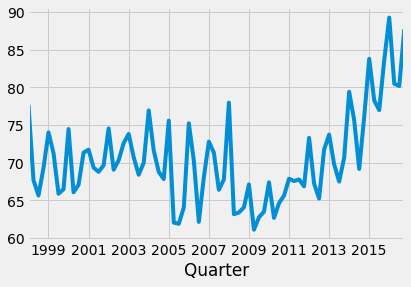

In [13]:
# Quick plot of timeline
plt.style.use('fivethirtyeight')
tour_trips.plot();

---
#### SARIMA Workflow

1. Format time-series
1. Visualize data
1. __Determine Seasonality $S$__
1. Ensure Stationarity (determine $d$ and $D$)
1. Determine $p$ and $q$ and $P$ and $Q$
1. Build model
1. Visualize model predictions

## Determining Seasonality

Before we get into determining seasonality, let's dive a little deeper into the 2 main kinds of seasonality.

### Additive vs. Multiplicative Seasonality

Simply put, seasonality can present itself in two ways:
1. __Additive:__ where over time the peaks and valleys keep the same magnitude over time.
2. __Multiplicative:__ where over time the peaks and valleys increase/decrease in magnitude over time.

The easiest way to determine which kind of seasonality you have is to plot the data over time:

#### Additive Seasonality
<img src="assets/adding.png" width="300px">

#### Multiplicative Seasonality
<img src="assets/multi.png" width="300px">

Once we determine which kind of seasonality is at play in our data, we can proceed to decompose our data properly.

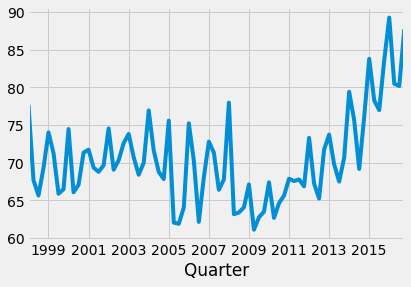

In [14]:
# Quick plot of timeline
tour_trips.plot();

__Take a look at our time series plot again. Which kind of seasonality do you think applies best?__

_Answer: Most likely additive_

#### An aside: order vs. seasonal order

When we worked with the ARIMA model, we had to describe the parameters of the model using the "order" in the form `(p, d, q)`, which referred to the AR, I, and MA components, respectively.

The SARIMA model still uses the same order as ARIMA, with an additional order known as the "seasonal order", which takes a similar form `(P, D, Q, S)`, which refers specifically to the seasonal components of the model. In this way, __SARIMA models effectively have TWO main models working under the hood__: (1) an ARIMA model and (2) an augmented ARIMA model tuned to work with seasonality.

### Determine the seasonal period ($S$)

The seasonal period is just the frequency of the data in a standardized form.

__Seasonal period or $S$ or `m`__ refers to the number of observations per seasonal cycle. This value generally requires subject matter knowledge of the data, but you can use the following guidelines to determine this value.

Data|	Frequency
:-:|:-:
Annual|	1
Quarterly|	4
Monthly	|12
Weekly	|52
Daily |7

Since our data is quarterly:
- $period = 4$
- $S = 4$
- `m = 4`

### Decomposing the data

Once we have a good idea of which kind of seasonality we have, we can use the `seasonal_decompose` function to __determine if seasonality is truly present in the data.__

_NOTE: If you try `model = "multiplicative"` you'll notice very odd residuals, which should let you know something's not quite right using "multiplicative"_

In [15]:
# decompose Trips using "additive" and a period of 4
decomposed_result = seasonal_decompose(tour_trips, model = "additive", period = 4)

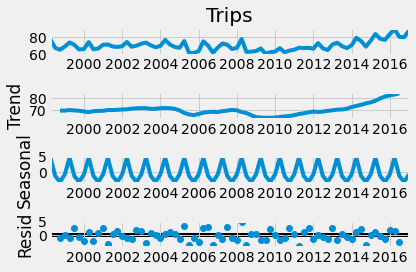

In [16]:
# plot decomposition
decomposed_result.plot();

__WARNING: The seasonal decomposition will ALWAYS pull out a seasonal component. You must look at the scale and shape of the plot and determine if significant.__

In [17]:
# use .describe() to get sense of scale
tour_trips.describe()

count    76.000000
mean     70.566124
std       5.993543
min      61.125197
25%      66.782542
50%      69.329371
75%      73.881543
max      89.260910
Name: Trips, dtype: float64

__Interpretation:__ Based on the decomposition of our variable, the seasonal component appears to play a significat scale (scale is $\pm 5$). Additionaly, it's common sense to consider trips as seasonal. Therefore, __we'll assume seasonality is playing a significant role in our data and we will proceed with a SARIMA model.__

---
#### SARIMA Workflow

1. Format time-series
1. Visualize data
1. Determine Seasonality $S$
1. __Ensure Stationarity (determine $d$ and $D$)__
1. Determine $p$ and $q$ and $P$ and $Q$
1. Build model
1. Visualize model predictions

## Determine $d$ and $D$

As usual, we'll just the Augmented Dickey-Fuller hypothesis test to ensure stationarity and determine $d$ and $D$. 

In [18]:
def interpret_dftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    dftest = adfuller(target_column)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [19]:
# original data (d = 0)
interpret_dftest(tour_trips)

Test Statistic   -0.070772
p-value           0.952273
dtype: float64

In [20]:
# once differenced data (d = 1)
interpret_dftest(tour_trips.diff().dropna())

Test Statistic   -3.330564
p-value           0.013566
dtype: float64

We've determined $d = 1$ and $D = 1$

---
#### SARIMA Workflow

1. Format time-series
1. Visualize data
1. Determine Seasonality $S$
1. Ensure Stationarity (determine $d$ and $D$)
1. __Determine $p$ and $q$ and $P$ and $Q$__
1. Build model
1. Visualize model predictions

## Determine $p$ and $q$ and $P$ and $Q$

We COULD look at the ACF and PACF graphs to help determine the AR and MA components for our orders. With enough practice and experience, we can elucidate these values directly (difficult - see local ARIMA lesson)...however, we could also use grid searching (easier).

Grid Search options:
- using `auto_arima`, which is a pre-made SARIMAX function for gridsearching both ARIMA and SARIMAX orders
- using a custom grid search function

### Using `auto_arima`

You may need to install the package first
```python
!pip install pmdarima
```

In [21]:
!pip install pmdarima

In [22]:
from pmdarima import auto_arima

### Model Preparation

Just like `GridSearchCV` we must be mindful not to leak information from our testing test into the searching process, so let's split our data now.


#### A few considerations:
1. Only using target (we won't be using exogenous variables, yet...)
1. `train_test_split` works with just a single Series
1. `shuffle = False` for time-series data

In [23]:
# ONLY using the target
y = tour_trips # for clarity

# NOTICE shuffle = False
y_train, y_test = train_test_split(y, test_size = .2, shuffle = False)

_Note: Sometimes, you have to do away with train/test splits! Time series data is often very small compared to the data sets we're used to. We may not always have the luxury of reserving data into a validation/test set._

In [24]:
stepwise_sarima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 1, # we know how much to difference, so don't need to waste time searching for this,
    D = 1, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = True, # use seasonality!
    m = 4, # MUST tell which seasonal period to use
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=329.057, Time=9.50 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=302.058, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=315.268, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=302.981, Time=0.69 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=313.402, Time=0.03 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=300.187, Time=0.07 sec
 ARIMA(2,1,0)(0,1,0)[4]             : AIC=312.214, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=299.227, Time=0.27 sec
 ARIMA(2,1,0)(3,1,0)[4]             : AIC=298.237, Time=0.17 sec
 ARIMA(2,1,0)(3,1,1)[4]             : AIC=inf, Time=1.48 sec
 ARIMA(2,1,0)(2,1,1)[4]             : AIC=inf, Time=0.99 sec
 ARIMA

_NOTE:_
- In general, the values for $p, q, P$ and $Q$ are typically low values - between 0 and 2, but can be more.
- By default, `auto_arima` will optimize for [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) to determine which values are best.
- `auto_arima` returns a fitted model (the best found), much like `GridSearchCV`, however this is NOT a model from `statsmodels`. - it's from `pmdarima`
- _We don't supply our differenced dataset - we supply the original dataset, since we're telling `auto_arima` that $d=1$ and $D=1$_
- _We can still use some intuition from the ACF and PACF to guild our process - this takes time and experience working with time-series data (see local ARIMA lesson)_

In [25]:
# What was the best order?
stepwise_sarima.order

(2, 1, 0)

In [26]:
# What was the best seasonal order?
stepwise_sarima.seasonal_order

(3, 1, 0, 4)

_NOTE: It's fairly common for $p = P$ and $q = Q$, though this will not always be the case._

In [27]:
# Check summary to ensure no problems
stepwise_sarima.summary()    # sigma2 is associated with intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   60
Model:             SARIMAX(2, 1, 0)x(3, 1, 0, 4)   Log Likelihood                -143.118
Date:                           Tue, 24 Aug 2021   AIC                            298.237
Time:                                   15:43:59   BIC                            310.281
Sample:                                        0   HQIC                           302.894
                                            - 60                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5358      0.149     -3.598      0.000      -0.828      -0.244
ar.L2         -0.3683      0.164     -2.252      0.024      -0.689      -0.048
ar.S.L4       -0.7146      0.124     -5.761      0.000      -0.958      -0.471
ar.S.L8       -0.4337      0.169     -2.563      0.010      -0.765      -0.102
ar.S.L12      -0.2394      0.180     -1.331      0.183      -0.592       0.113
sigma2        10.0733      2.151      4.684      0.000       5.858      14.288
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.83   Prob(JB):                         0.52
Heteroskedasticity (H):               1.33   Skew:                            -0.34
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

__If you find `nan` values in the coefficients, then something bad happened and you should reconsider your options:__
1. Try another solver (depends on data - try `solver = "powell"`)
1. Ensure stationarity

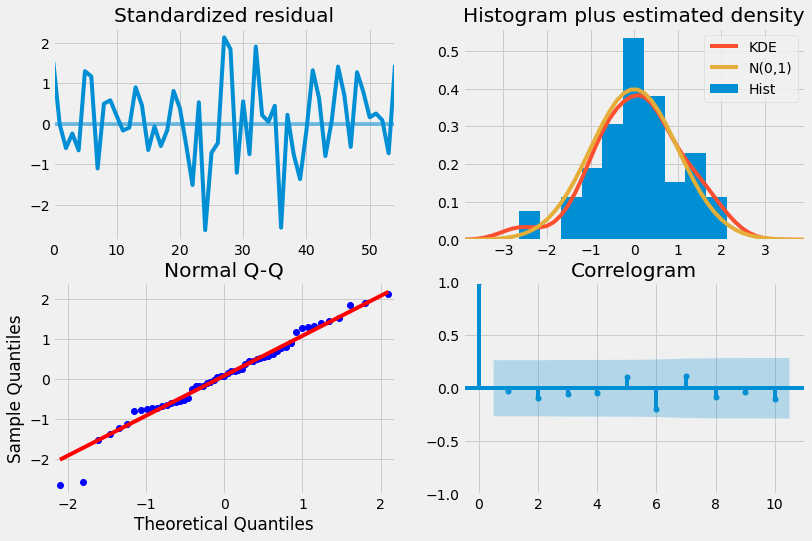

In [28]:
# Some nice quick graphs of results
stepwise_sarima.plot_diagnostics(figsize = (12, 8));

### Using a custom time series grid search

_The following function was modified from the Global ARIMA lesson_

Our strategy is this:

1. Let's start AIC at some really, really big number and call it `best_aic`.
1. We'll also instantiate `best_model`, `best_order`, and `best_seasonal_order`
1. Create a nested for loop to iterate over our possible values of $p, q, P$ and $Q$.
    1. At every combination of $p, q, P$ and $Q$, fit an SARIMA model.
    1. If the SARIMA model has a better (lower) AIC than `best_aic`, then store the best order and seasonal order along with the model!
1. At the end of the for loop, return the orders and the best model (lowest AIC).


_NOTE: While we are not using exogenous variables yet, the `SARIMAX` model works just fine without it! So, we'll be using it without the "X"._

In [29]:
def sarima_grid_search(data, p_range = (0,2), q_range = (0,2), P_range = (0,2), Q_range = (0,2), d = 0, D = 0, S = 12, verbose = False):
    best_aic = 99 * (10 ** 16) # a very large number
    best_order = None
    best_seasonal_order = None
    best_model = None
    # Use nested for loop to iterate over values of p and q.
    for p in range(p_range[0], p_range[1] + 1): # adding 1 so range is inclusive
        for q in range(q_range[0], q_range[1] + 1): # adding 1 so range is inclusive
            for P in range(P_range[0], P_range[1] + 1): # adding 1 so range is inclusive
                for Q in range(Q_range[0], Q_range[1] + 1): # adding 1 so range is inclusiv
                    # Insert try and except statements.
                    try:
                        # Fitting an SARIMA(p, d, q) & (P, D, Q, S) model.
                        if verbose:
                            print(f'Attempting to fit SARIMA({p},{d},{q}) & ({P},{D},{Q},{S})')
                        order = (p,d,q) # values of p, d, q
                        seasonal_order = (P, D, Q, S)
                        # Instantiate SARIMA model.
                        sarima = SARIMAX(endog = data.astype(float).dropna(), # endog = Y variable
                                      order = order,
                                      seasonal_order = seasonal_order) 

                        # Fit SARIMA model.
#                         model = sarima.fit()
                        # If getting Convergence Errors, try increasing maxiter and changing method
                        model = sarima.fit(maxiter = 200, method = "powell", disp = 0) # disp = 0 b/c of excessive output
                        

                        if verbose:
                            print(f'The AIC for SARIMA({p},{d},{q})  & ({P},{D},{Q},{S}) is: {model.aic}')

                        # Is my current model's AIC better than our best_aic?
                        if model.aic < best_aic:

                            # If so, let's overwrite best found so far
                            best_aic = model.aic
                            best_order = order
                            best_seasonal_order = seasonal_order
                            best_model = model

                    except Exception as e:
                        print(e)
                        pass

    return {
        "best_aic": best_aic, 
        "best_order" : best_order, 
        "best_seasonal_order" : best_seasonal_order, 
        "best_model": best_model
    }

In [30]:
# try out function on our data
sarima_gd_result = sarima_grid_search(y_train, d = 1, D = 1, S = 4, verbose = True)

Attempting to fit SARIMA(0,1,0) & (0,1,0,4)
The AIC for SARIMA(0,1,0)  & (0,1,0,4) is: 329.0567806756472
Attempting to fit SARIMA(0,1,0) & (0,1,1,4)
The AIC for SARIMA(0,1,0)  & (0,1,1,4) is: 299.04357179517115
Attempting to fit SARIMA(0,1,0) & (0,1,2,4)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMA(0,1,0)  & (0,1,2,4) is: 300.8825504445492
Attempting to fit SARIMA(0,1,0) & (1,1,0,4)
The AIC for SARIMA(0,1,0)  & (1,1,0,4) is: 313.4024190801464
Attempting to fit SARIMA(0,1,0) & (1,1,1,4)
The AIC for SARIMA(0,1,0)  & (1,1,1,4) is: 300.8276289978966
Attempting to fit SARIMA(0,1,0) & (1,1,2,4)
The AIC for SARIMA(0,1,0)  & (1,1,2,4) is: 300.0173923531189
Attempting to fit SARIMA(0,1,0) & (2,1,0,4)
The AIC for SARIMA(0,1,0)  & (2,1,0,4) is: 312.0396602443709
Attempting to fit SARIMA(0,1,0) & (2,1,1,4)
The AIC for SARIMA(0,1,0)  & (2,1,1,4) is: 302.8852193507859
Attempting to fit SARIMA(0,1,0) & (2,1,2,4)
The AIC for SARIMA(0,1,0)  & (2,1,2,4) is: 301.7872112652657
Attempting to fit SARIMA(0,1,1) & (0,1,0,4)
The AIC for SARIMA(0,1,1)  & (0,1,0,4) is: 309.13357113117127
Attempting to fit SARIMA(0,1,1) & (0,1,1,4)
The AIC for SARIMA(0,1,1)  & (0,1,1,4) is: 286.02807784169414
Attempting to fit SARIMA(0,1,1) & (0,1,2,4)
The AIC for SARIMA(0,1,1)  & (0,1,2,4) is: 287.937734

The AIC for SARIMA(2,1,2)  & (2,1,2,4) is: 293.7969309572755


#### An aside: Convergence Warnings

When estimating the coefficients, your model may not be able to converge and will give you the dreaded `ConvergenceWarning`

If this happens, I would suggest 2 remedies:
1. Increase your `maxiter` (default is 50)
2. Change the `method` (default is 'lbfgs')

For example:
```python
...
fitted_model = model.fit(maxiter = 200, method = "powell")
...
```

_NOTES:_
- _If the likelihood function is flat, and/or has many local minima the "powell" method (which is a derivative-free method) helps._
- _SARIMAX is a "blunt" tool and will have trouble honing in on high frequency (granular) data. If your data is too granular, consider downsampling._

In [31]:
# check result
sarima_gd_result

{'best_aic': 286.02807784169414,
 'best_order': (0, 1, 1),
 'best_seasonal_order': (0, 1, 1, 4),
 'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fba1a128f40>}

_NOTE: your custom grid search results may disagree with the `auto_arima` as they handle the task in different ways. As you get more familiar with working with time-series data, you'll gain more insight in determining the AR and MA components._

---
#### SARIMA Workflow

1. Format time-series
1. Visualize data
1. Determine Seasonality $S$
1. Ensure Stationarity (determine $d$ and $D$)
1. Determine $p$ and $q$ and $P$ and $Q$
1. __Build model__
1. Visualize model predictions

## Modeling

Notes:
1. Use `enforce_stationarity = False` since we tell the model what the proper differencing is using $d$ and $D$
1. We can set `freq` as quarterly, `"Q"`. While this is not entirely necessary, it serves as a good check to being explicit with your intention for what the expected input should be
1. If you're having convergence warnings, try:
    1. Increasing `maxiter`
    1. Changing the solver (for example: `method = "powell"`)

In [32]:
order = (2, 1, 0)
seasonal_order = (3, 1, 0, 4)

# instantiate
tour_sarima = SARIMAX(
    y_train, 
    order = order, 
    seasonal_order = seasonal_order, 
    freq = "Q", # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
fitted_tour_sarima = tour_sarima.fit() # stats model returns fitted model

# fit, in case of convergence warning
# fitted_tour_sarima = tour_sarima.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

In [33]:
# always check summary for issues
fitted_tour_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Trips   No. Observations:                   60
Model:             SARIMAX(2, 1, 0)x(3, 1, 0, 4)   Log Likelihood                -107.710
Date:                           Tue, 24 Aug 2021   AIC                            227.420
Time:                                   16:16:11   BIC                            237.701
Sample:                               03-31-1998   HQIC                           231.163
                                    - 12-31-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4938      0.183     -2.699      0.007      -0.852      -0.135
ar.L2         -0.3742      0.187     -1.996      0.046      -0.742      -0.007
ar.S.L4       -0.7460      0.148     -5.058      0.000      -1.035      -0.457
ar.S.L8       -0.5542      0.192     -2.891      0.004      -0.930      -0.178
ar.S.L12      -0.2837      0.196     -1.450      0.147      -0.667       0.100
sigma2        11.2038      2.759      4.061      0.000       5.797      16.611
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.71   Prob(JB):                         0.78
Heteroskedasticity (H):               0.63   Skew:                            -0.27
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---
#### SARIMA Workflow

1. Format time-series
1. Visualize data
1. Determine Seasonality $S$
1. Ensure Stationarity (determine $d$ and $D$)
1. Determine $p$ and $q$ and $P$ and $Q$
1. Build model
1. __Visualize model predictions__

## Visualizing Predictions

#### Creating `plot_SARIMA_predictions` visualization function
The following cell contains a graphing function we'll use after getting predictions.

In [34]:
def plot_SARIMA_predictions(y_train, y_test = None, train_preds = None, test_preds = None, lower_conf_int = None, upper_conf_int = None, title = "Title", ylabel = "{y_label}",xlabel = "Data"):
    plt.figure(figsize=(12,5))
    plt.title(title)

    # train data
    plt.plot(y_train.index, y_train, lw=1, color='purple', ls='solid', label='Train Data')

    # train prediction
    if train_preds is not None:
        plt.plot(train_preds.index, train_preds, lw=1, color='green', ls='dashed', label='Training Predictions')

    # test data
    if y_test is not None:
        plt.plot(y_test.index, y_test, lw=1, color='blue', ls='solid',label='Test Data')

    # test predictions
    if test_preds is not None:
        plt.plot(test_preds.index, test_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')

    #  labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # confidence intervals
    if lower_conf_int is not None and upper_conf_int is not None:
        plt.fill_between(y_test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1,  label ="95% conf. int.");
    # legend
    plt.legend(loc = "upper left");


### Making predictions with.... `.forecast` vs. `.predict` vs. `.fittedvalues` vs. `.get_forecast`

The SARIMA models have a few ways of making predictions. We'll cover some of the nuances here.

### Using `.forecast`

`.forecast` does what it sounds like it does. It has one main parameter `steps`, which corresponds to the number of time intervals to predict AFTER the end of the training set.

However, this version of `.forecast` does not work like it's ARIMA counterpart. The SARIMAX `.forecast` method returns only the forecasted values (no standard error or confidence intervals)

__You might imagine, we'd be interested in forecasting the length of the testing set, which will serve as a way of testing our model's predictions.__

In [35]:
# forecast len(y_test)
num_steps = len(y_test)
test_forecast = fitted_tour_sarima.forecast(steps = num_steps)

test_forecast.head()

2013-03-31    73.802175
2013-06-30    67.878090
2013-09-30    69.797479
2013-12-31    71.573645
2014-03-31    74.608705
Freq: Q-DEC, Name: predicted_mean, dtype: float64

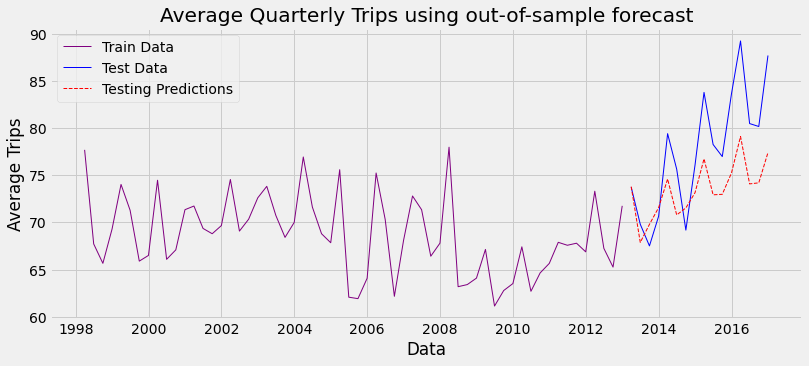

In [37]:
# plotting out-of-sample
plot_SARIMA_predictions(
    y_train, 
    y_test, 
    test_preds = test_forecast,
    title = "Average Quarterly Trips using out-of-sample forecast",
    ylabel = "Average Trips"
)

_NOTE: `.forecast` by default works __"out-of-sample" meaning the prediction from one step is used to determine the prediction on the next step.___


### Using `.predict`

`.predict` works much like how we're used to working with predictions.

There are 3 main parameters to consider:
- `start` = the index from the __training set__ to start predicting from (can also be a datetime string or a 'datetime' type)
- `end`   = the index from the __training set__ to stop predicting at (can also be a datetime string or a 'datetime' type)
- `dynamic` = to __predict "in-sample" (False : default)__ or "out-of-sample" (True)

#### An aside: using correct length of predictions 

Recall that "under the hood" the model is differencing our data. __When we set $d = 1$ and $D = 1$, we must keep in mind that we lose the first observation__ from the training set. So, when we call on our model to make predictions, we must likewise start at 1 more than the starting index.

In [38]:
# creating testing predictions
test_preds = fitted_tour_sarima.predict(start = len(y_train), end = len(y_train) + len(y_test) - 1)

_Note the `len(y_train) + len(y_test) - 1` - subtracting 1 keeps the test lengths in alignement_

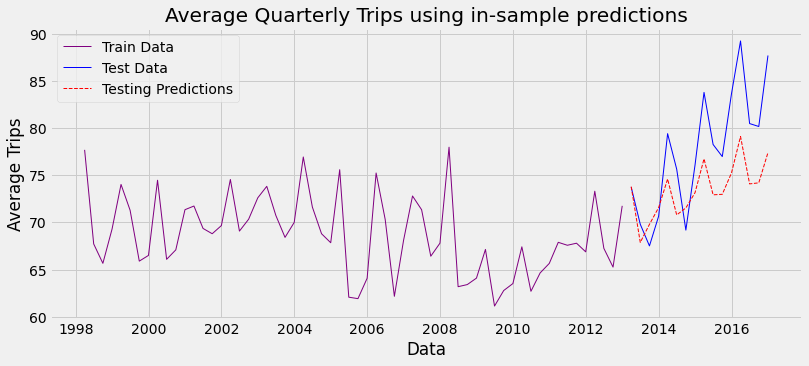

In [39]:
# plotting in-sample
plot_SARIMA_predictions(
    y_train, 
    y_test,  
    test_preds = test_preds,
    title = "Average Quarterly Trips using in-sample predictions",
    ylabel = "Average Trips"
)

__Why do our predictions look like the "out-of-sample" forecast from before?__

_Answer:_ The model doesn't have any "in-sample" data to go off of, so it will use previous predictions.

### Using `.fittedvalues`

`.fittedvalues` is actually an attribute (not a method) and refers to the internally stored training predictions.

That's right, you don't have to `.predict` the training set!

However, we must keep in mind the need to consider the affect of differencing on our predictions.

In [40]:
# check out fitted_tour_sarima.fittedvalues
fitted_tour_sarima.fittedvalues.head()

Quarter
1998-03-31      0.000000
1998-06-30     64.913445
1998-09-30     63.755442
1998-12-31     71.400217
1999-03-31    100.677866
Freq: Q-DEC, dtype: float64

Notice how the first observation is 0. This is to keep the length the same as the training set.

In [41]:
print("Length of training dataset:", len(y_train))
print("Length of .fittedvalues:", len(fitted_tour_sarima.fittedvalues))

Length of training dataset: 60
Length of .fittedvalues: 60


If we used these values as is, we'd get some bad graphs and a poor result!

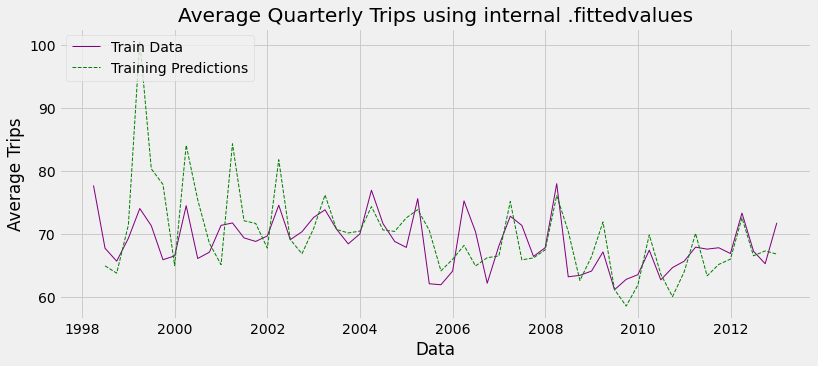

In [43]:
# plotting .fittedvalues (wrong)
plot_SARIMA_predictions(
    y_train, 
    train_preds = fitted_tour_sarima.fittedvalues[1:], 
    title = "Average Quarterly Trips using internal .fittedvalues",
    ylabel = "Average Trips"
)

Notice the 0 at the start of the graph makes it seem like our model was very bad at predicting on the dataset.

We MUST take into account the differencing taking place. In our case, we had a value of $d = 1$ and $D = 1$, so we lost the first value in our training set.

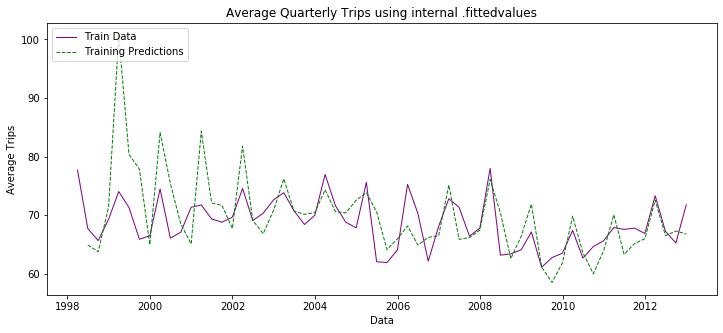

In [101]:
# plotting .fittedvalues (correct)
plot_SARIMA_predictions(
    y_train, 
    train_preds = fitted_tour_sarima.fittedvalues[1:],    # start from 1 , not 0
    title = "Average Quarterly Trips using internal .fittedvalues",
    ylabel = "Average Trips"
)

_NOTE: In practice, the training predictions for time-series models are less relevant, since the main concern it the validity of the model predictions AFTER training._

#### An aside: What about that early spike in the training set?

Let's see what happend if we start the prediction process VERY early on.

In [45]:
# creating EARLY testing predictions
early_test_preds = fitted_tour_sarima.predict(start = 2, end = len(y_train) - 1)

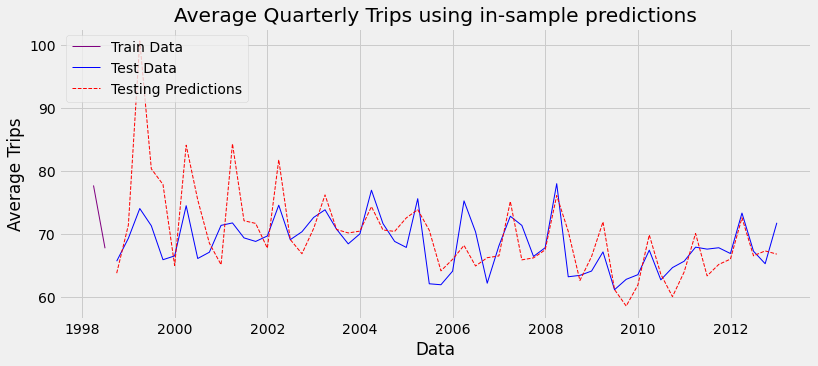

In [46]:
# plotting early in-sample predictions
plot_SARIMA_predictions(
    y_train = y_train[:2], 
    y_test = y_train[2:],
    test_preds = early_test_preds,
    title = "Average Quarterly Trips using in-sample predictions",
    ylabel = "Average Trips"
)

This is very telling! It shouldn't be surprising for the initial model predictions to be bad, since up until that early point, there is so little data to go off of.

### Using `.get_forecast` and `.get_prediction`

`.get_forecast` works in a similar way to how `.forecast` works - it uses 1 main parameter, `steps` and it makes forecasts "out-of-sample". However, `.get_forecast` does not return the forecasted values. Instead, it returns an object containing the forecasted values AND the confidence interval!

Similarly, `.get_prediction` works like `.predict`, taking a `start`, `end`, etc. and returns an object we can extract the predicted values AND the confidence interval from!

Let's use `.get_forecast` to get the test predictions AND their associated confidence interval.
- The forecast values are contained in the object's `.predicted_mean` attribute
    - _NOTE: these are the literal values as a numpy array, NOT a pandas Series, so you'll likely want to create your own Series with the associated datetime index_
- The confidence intervals are returns from calling the `.conf_int()` method

In [47]:
# get forecast object
forecast_object = fitted_tour_sarima.get_forecast(steps = len(y_test))

# grab forecasted values
forecast_pred_values = forecast_object.predicted_mean
# converting to pandas Seried with proper datetime index
forecast_preds = pd.Series(forecast_pred_values, index = y_test.index)

# grab confidence intervals
pred_ci = forecast_object.conf_int()

# break out lower and upper confidence values
lower_conf_int = pred_ci.iloc[:,0]
upper_conf_int = pred_ci.iloc[:,1]

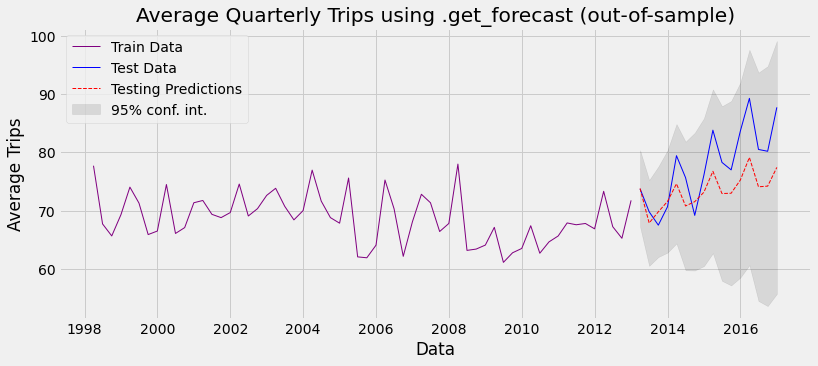

In [48]:
# plotting .get_forecast
plot_SARIMA_predictions(
    y_train, 
    y_test,
    test_preds = forecast_preds,
    lower_conf_int = lower_conf_int,
    upper_conf_int = upper_conf_int,
    title = "Average Quarterly Trips using .get_forecast (out-of-sample)",
    ylabel = "Average Trips"
)

__Why does the confidence interval get larger the further out the prediction goes?__

_Answer: Intuitively, the further into the future we forecase, the less confident we are._

__Why is the confidence interval so important?__

_Answer: The uncertainty of the forecast is just as important as, or even more so, than the forecast itself!_ 

### Model Scoring

In [49]:
# Train score (from .fittedvalues)
r2_score(y_train[fitted_tour_sarima.fittedvalues[1:].index], fitted_tour_sarima.fittedvalues[1:])

-0.9562128643965204

In [50]:
# Test score (from .forecast)
r2_score(y_test[forecast_preds.index], forecast_preds)

0.17886078233587033

Clearly our model was not able to handle the sudden change that occured in our test set.

Also, the baseline model is quite good!

In [51]:
# test pred RSS 
np.sqrt(np.sum((y_test[forecast_preds.index] - forecast_preds)**2))

22.83149858663832

In [52]:
# baseline RSS
np.sqrt(np.sum((y_test - np.mean(y_test))**2))

25.195676341112684

Our baseline model is surprisingly good on the test set, making it hard to beat!

---
Also, notice we haven't done any cross validation! 

This is because __cross validation isn't much help for time-series data.__ At best, cross validation is tricky to set up for time series models, and at worst it's not applicable at all! 

Think about how that would even work...since everything is time dependent, we can't train our models on future data - that would cause leakage.

### Multi-Step Out-of-Sample Forecasting

What is we simulated the real world?

Say, for each quarter, we'll use all of the previous information we have to build our SARIMA model to make the prediction for JUST the next quarter.
- For each observation in our test dataset:
    - We'll build a new model using the previously accumulated data points to train on
    - We'll forecast the next step and add the TRUE value of that step to the "history"
- Repeat for each test observation


In [53]:
# Set up the orders
order          = (2, 1, 0)
seasonal_order = (3, 1, 0, 4)

# storing new test predictions, the history, and confidence intervals
temp_test_preds = []
history = y_train.values
conf_ints = []

# for each test observation...
for val in y_test:
    # create model
    sarima = SARIMAX(history, order = order, seasonal_order = seasonal_order, enforce_stationarity = False)
    # fit
    fitted_sarima = sarima.fit(method = "powell", maxiter = 200, disp = 0) # stop excessive ouput with disp = 0
    # make next out-of-sample prediction
    pred_obj = fitted_sarima.get_forecast(steps = 1)
    # add to preds and conf_ints
    temp_test_preds.append(pred_obj.predicted_mean)
    conf_ints.append(pred_obj.conf_int()[0])

    # add TRUTH to history for next training
    history = np.append(history, val)

In [54]:
# setting up info for visualization
new_test_preds = pd.Series(temp_test_preds, index = y_test.index)

# converting list to numpy array for convenience
lower_conf_int = np.array(conf_ints)[:,0]
upper_conf_int = np.array(conf_ints)[:,1]

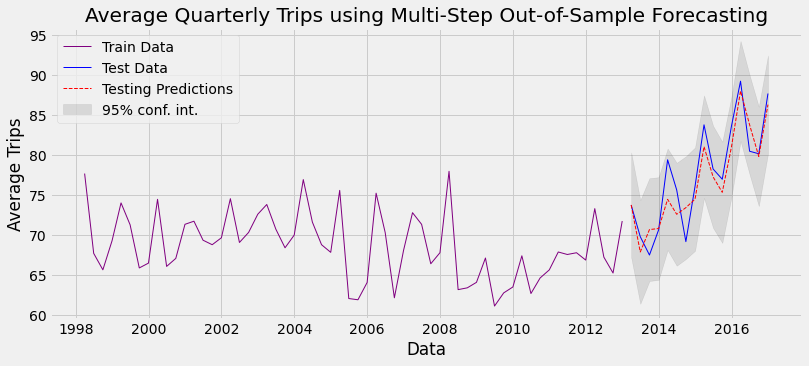

In [55]:
# plotting Multi-Step Out-of-Sample Forecasting
plot_SARIMA_predictions(
    y_train, 
    y_test,
    test_preds = new_test_preds,
    lower_conf_int = lower_conf_int,
    upper_conf_int = upper_conf_int,
    title = "Average Quarterly Trips using Multi-Step Out-of-Sample Forecasting",
    ylabel = "Average Trips"
)

This shows a more realistic view of how our model would perform "in action" during those months.

In [56]:
# Multi-Step Out-of-Sample Forecasting Test score
r2_score(y_test, new_test_preds)

0.8416033292914202

### Ways to solve time-series problems
1. ~~__Keep using a standard model (like linear regression)__ with engineered features related to time~~
2. ~~__Basic ARIMA model__ using ONLY the target variable~~
3. ~~__ARIMAX model__ using the target AND exogenous variables, which can include engineered features related to time~~
4. ~~__SARIMA model__ adding a seasonality component to ARIMA~~
5. __SARIMAX model__ adding a seasonality component to ARIMAX
6. __Vector AutoRegressive (VAR) model__ if you need to predict using other predictions as input (akin to transfer learning)

## SARIMAX: tossing an X on the end of SARIMA

### Air Pollution Dataset

These data are from refinery monitoring stations in Atchison Village, Richmond CA, United States.

https://www.kaggle.com/nicapotato/pollution-in-atchison-village-richmond-ca

_NOTE: For brevity, the following will be a VERY abridged workflow!_

In [57]:
desired_cols = ["Date", "Wind Speed", "Benzene","CS2","SO2", "Toluene", "Xylene", "Ozone"]

air_pol = pd.read_csv("datasets/air_pollution.csv", parse_dates=["Date"], index_col = ["Date"], usecols = desired_cols)

In [58]:
# ALWAYS sort time index
air_pol.sort_index(inplace = True)

In [60]:
# resampling by day (too granular otherwise)
air_pol = air_pol.resample("D").mean()
air_pol.head(2)

,Benzene,CS2,Ozone,SO2,Toluene,Xylene,Wind Speed
Date,,,,,,,
2015-08-01,2.5,2.5,17.659514,2.5,2.5,2.5,8.656250
2015-08-02,2.5,2.5,14.584410,2.5,2.5,2.5,7.381944


How much data do we have?

In [55]:
air_pol.shape

(111, 7)

111 observations! That's barely anything at all!

__We'll have to forego making a train/test split, in order to have any chance of maintaining a good model__

### Determine $S$

Since our data will be daily, $S = 7$

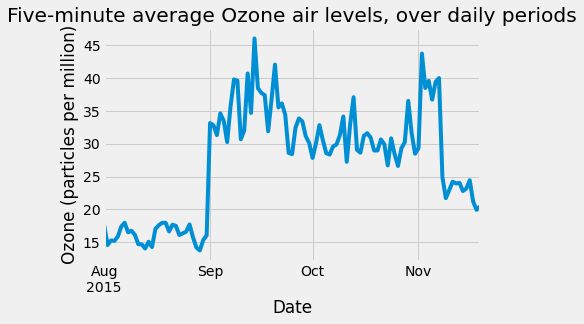

In [61]:
# quick plot of target vs. time 
air_pol["Ozone"].plot();
plt.ylabel("Ozone (particles per million)")
plt.title("Five-minute average Ozone air levels, over daily periods");

### Determine $d$ and $D$

In [62]:
# original data
interpret_dftest(air_pol["Ozone"])

Test Statistic   -1.979462
p-value           0.295650
dtype: float64

In [63]:
# d = 1
air_diff_1 = air_pol["Ozone"].diff().dropna()
interpret_dftest(air_diff_1)

Test Statistic   -9.890178e+00
p-value           3.575236e-17
dtype: float64

We can conclude $d = 1$ and $D = 1$

### Model preparation

In [64]:
X = air_pol.drop(columns=["Ozone"])
y = air_pol["Ozone"] 

# NO TRAIN/TEST SPLIT - too little data

In [60]:
X.head(2)

,Benzene,CS2,SO2,Toluene,Xylene,Wind Speed
Date,,,,,,
2015-08-01,2.5,2.5,2.5,2.5,2.5,8.656250
2015-08-02,2.5,2.5,2.5,2.5,2.5,7.381944


### Using `auto_arima` to determine other components

_Notice how we'll need to provide our exogenous variables into the process._

In [65]:
sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 1, # we know how much to difference, so don't need to waste time searching for this,
    D = 1, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = True, # use seasonality!
    m = 7, # MUST tell which seasonal period to use
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=629.913, Time=1.40 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=600.028, Time=1.61 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=575.904, Time=2.86 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=625.463, Time=0.46 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=577.730, Time=2.21 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=577.703, Time=2.72 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=598.279, Time=1.38 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.98 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=577.573, Time=2.12 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=576.770, Time=2.24 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=576.003, Time=2.70 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=577.080, Time=3.14 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=578.252, Time=2.19 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,1,1)(0,1,1)[7]          
Total fit

In [66]:
# Check orders
print("order: ", sarimax.order)
print("seasonal_order: ", sarimax.seasonal_order)

order:  (0, 1, 1)
seasonal_order:  (0, 1, 1, 7)


### Using custom grid search to determine other components

In [67]:
def sarimax_grid_search(endog, exog, p_range = (0,2), q_range = (0,2), P_range = (0,2), Q_range = (0,2), d = 0, D = 0, S = 12, verbose = False):
    best_aic = 99 * (10 ** 16) # a very large number
    best_order = None
    best_seasonal_order = None
    best_model = None
    # Use nested for loop to iterate over values of p and q.
    for p in range(p_range[0], p_range[1] + 1): # adding 1 so range is inclusive
        for q in range(q_range[0], q_range[1] + 1): # adding 1 so range is inclusive
            for P in range(P_range[0], P_range[1] + 1): # adding 1 so range is inclusive
                for Q in range(Q_range[0], Q_range[1] + 1): # adding 1 so range is inclusiv
                    # Insert try and except statements.
                    try:
                        # Fitting an SARIMAX(p, d, q) & (P, D, Q, S) model.
                        if verbose:
                            print(f'Attempting to fit SARIMAX({p},{d},{q}) & ({P},{D},{Q},{S})')
                        order = (p,d,q) # values of p, d, q
                        seasonal_order = (P, D, Q, S)
                        # Instantiate SARIMA model.
                        sarima = SARIMAX(endog = endog.astype(float).dropna(), # endog = Y variable
                                         exog = exog.astype(float).dropna(), # INCLUDING EXOGENOUS VARIABLES
                                      order = order,
                                      seasonal_order = seasonal_order) 

                        # Fit SARIMAX model.
                        # model = sarima.fit()
                        # If getting Convergence Errors, try increasing maxiter and changing method
                        model = sarima.fit(maxiter = 200, method = "powell", disp = 0) # disp = 0 b/c of excessive output

                        if verbose:
                            print(f'The AIC for SARIMAX({p},{d},{q})  & ({P},{D},{Q},{S}) is: {model.aic}')

                        # Is my current model's AIC better than our best_aic?
                        if model.aic < best_aic:

                            # If so, let's overwrite best found so far
                            best_aic = model.aic
                            best_order = order
                            best_seasonal_order = seasonal_order
                            best_model = model

                    except Exception as e:
                        print(e)
                        pass

    return {
        "best_aic": best_aic, 
        "best_order" : best_order, 
        "best_seasonal_order" : best_seasonal_order, 
        "best_model": best_model
    }

In [68]:
# try out function on our data (with exog)
sarimax_gs_result = sarimax_grid_search(y, X, d = 1, D = 1, S = 7, verbose = True)

Attempting to fit SARIMAX(0,1,0) & (0,1,0,7)
The AIC for SARIMAX(0,1,0)  & (0,1,0,7) is: 629.9130213138351
Attempting to fit SARIMAX(0,1,0) & (0,1,1,7)
The AIC for SARIMAX(0,1,0)  & (0,1,1,7) is: 577.706956404716
Attempting to fit SARIMAX(0,1,0) & (0,1,2,7)
The AIC for SARIMAX(0,1,0)  & (0,1,2,7) is: 579.6685363299241
Attempting to fit SARIMAX(0,1,0) & (1,1,0,7)
The AIC for SARIMAX(0,1,0)  & (1,1,0,7) is: 602.593431057602
Attempting to fit SARIMAX(0,1,0) & (1,1,1,7)
The AIC for SARIMAX(0,1,0)  & (1,1,1,7) is: 579.4574839598232
Attempting to fit SARIMAX(0,1,0) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(0,1,0)  & (1,1,2,7) is: 576.0510208881911
Attempting to fit SARIMAX(0,1,0) & (2,1,0,7)
The AIC for SARIMAX(0,1,0)  & (2,1,0,7) is: 584.0561203129482
Attempting to fit SARIMAX(0,1,0) & (2,1,1,7)
The AIC for SARIMAX(0,1,0)  & (2,1,1,7) is: 580.63931613385
Attempting to fit SARIMAX(0,1,0) & (2,1,2,7)
The AIC for SARIMAX(0,1,0)  & (2,1,2,7) is: 573.2084705359199
Attempting to fit SARIMAX(0,1,1) & (0,1,0,7)
The AIC for SARIMAX(0,1,1)  & (0,1,0,7) is: 625.3989339700161
Attempting to fit SARIMAX(0,1,1) & (0,1,1,7)
The AIC for SARIMAX(0,1,1)  & (0,1,1,7) is: 576.1521746577253
Attempting to fit SARIMAX(0,1,1) & (0,1,2,7)
The AIC for SARIMAX(0,1,1)  & (0,1,2,7) is: 578.1845096653168
Attempting to fit SARIMAX(0,1,1) & (1,1,0,7)
The AIC for SARIMAX(0,1,1)  & (1,1,0,7) is: 598.2882144171257
Attempting to fit SARIMAX(0,1,1) & (1,1,1,7)
The AIC for SARIMAX(0,1,1)  & (1,1,1,7) is: 577.9181483394606
Attempting to fit SARIMAX(0,1,1) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(0,1,1)  & (1,1,2,7) is: 574.6153309390546
Attempting to fit SARIMAX(0,1,1) & (2,1,0,7)
The AIC for SARIMAX(0,1,1)  & (2,1,0,7) is: 581.6589017786341
Attempting to fit SARIMAX(0,1,1) & (2,1,1,7)
The AIC for SARIMAX(0,1,1)  & (2,1,1,7) is: 579.3410766801676
Attempting to fit SARIMAX(0,1,1) & (2,1,2,7)
The AIC for SARIMAX(0,1,1)  & (2,1,2,7) is: 571.9898318157019
Attempting to fit SARIMAX(0,1,2) & (0,1,0,7)
The AIC for SARIMAX(0,1,2)  & (0,1,0,7) is: 626.3016626376946
Attempting to fit SARIMAX(0,1,2) & (0,1,1,7)
The AIC for SARIMAX(0,1,2)  & (0,1,1,7) is: 576.0639225695222
Attempting to fit SARIMAX(0,1,2) & (0,1,2,7)
The AIC for SARIMAX(0,1,2)  & (0,1,2,7) is: 578.1641052937446
Attempting to fit SARIMAX(0,1,2) & (1,1,0,7)
The AIC for SARIMAX(0,1,2)  & (1,1,0,7) is: 599.5039300969343
Attempting to fit SARIMAX(0,1,2) & (1,1,1,7)
The AIC for SARIMAX(0,1,2)  & (1,1,1,7) is: 577.9660347417392
Attempting to fit SARIMAX(0,1,2) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(0,1,2)  & (1,1,2,7) is: 574.5171487105491
Attempting to fit SARIMAX(0,1,2) & (2,1,0,7)
The AIC for SARIMAX(0,1,2)  & (2,1,0,7) is: 583.1204482794948
Attempting to fit SARIMAX(0,1,2) & (2,1,1,7)
The AIC for SARIMAX(0,1,2)  & (2,1,1,7) is: 579.2524960466803
Attempting to fit SARIMAX(0,1,2) & (2,1,2,7)
The AIC for SARIMAX(0,1,2)  & (2,1,2,7) is: 572.4590512924751
Attempting to fit SARIMAX(1,1,0) & (0,1,0,7)
The AIC for SARIMAX(1,1,0)  & (0,1,0,7) is: 627.3472556745878
Attempting to fit SARIMAX(1,1,0) & (0,1,1,7)
The AIC for SARIMAX(1,1,0)  & (0,1,1,7) is: 577.3020698985265
Attempting to fit SARIMAX(1,1,0) & (0,1,2,7)
The AIC for SARIMAX(1,1,0)  & (0,1,2,7) is: 579.2863565549252
Attempting to fit SARIMAX(1,1,0) & (1,1,0,7)
The AIC for SARIMAX(1,1,0)  & (1,1,0,7) is: 599.9120936535863
Attempting to fit SARIMAX(1,1,0) & (1,1,1,7)
The AIC for SARIMAX(1,1,0)  & (1,1,1,7) is: 579.0621426065908
Attempting to fit SARIMAX(1,1,0) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(1,1,0)  & (1,1,2,7) is: 575.7996550603522
Attempting to fit SARIMAX(1,1,0) & (2,1,0,7)
The AIC for SARIMAX(1,1,0)  & (2,1,0,7) is: 582.6674466873361
Attempting to fit SARIMAX(1,1,0) & (2,1,1,7)
The AIC for SARIMAX(1,1,0)  & (2,1,1,7) is: 580.3621493751358
Attempting to fit SARIMAX(1,1,0) & (2,1,2,7)
The AIC for SARIMAX(1,1,0)  & (2,1,2,7) is: 572.9122438585574
Attempting to fit SARIMAX(1,1,1) & (0,1,0,7)
The AIC for SARIMAX(1,1,1)  & (0,1,0,7) is: 626.7900513194853
Attempting to fit SARIMAX(1,1,1) & (0,1,1,7)
The AIC for SARIMAX(1,1,1)  & (0,1,1,7) is: 576.896154389961
Attempting to fit SARIMAX(1,1,1) & (0,1,2,7)
The AIC for SARIMAX(1,1,1)  & (0,1,2,7) is: 578.9549079352552
Attempting to fit SARIMAX(1,1,1) & (1,1,0,7)
The AIC for SARIMAX(1,1,1)  & (1,1,0,7) is: 599.8856026416521
Attempting to fit SARIMAX(1,1,1) & (1,1,1,7)
The AIC for SARIMAX(1,1,1)  & (1,1,1,7) is: 578.7197281148514
Attempting to fit SARIMAX(1,1,1) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(1,1,1)  & (1,1,2,7) is: 575.3172029976436
Attempting to fit SARIMAX(1,1,1) & (2,1,0,7)
The AIC for SARIMAX(1,1,1)  & (2,1,0,7) is: 583.5453953856685
Attempting to fit SARIMAX(1,1,1) & (2,1,1,7)
The AIC for SARIMAX(1,1,1)  & (2,1,1,7) is: 580.0127294036339
Attempting to fit SARIMAX(1,1,1) & (2,1,2,7)
The AIC for SARIMAX(1,1,1)  & (2,1,2,7) is: 573.0921657312955
Attempting to fit SARIMAX(1,1,2) & (0,1,0,7)
The AIC for SARIMAX(1,1,2)  & (0,1,0,7) is: 627.90732469893
Attempting to fit SARIMAX(1,1,2) & (0,1,1,7)
The AIC for SARIMAX(1,1,2)  & (0,1,1,7) is: 577.8280641373334
Attempting to fit SARIMAX(1,1,2) & (0,1,2,7)
The AIC for SARIMAX(1,1,2)  & (0,1,2,7) is: 579.9301807162814
Attempting to fit SARIMAX(1,1,2) & (1,1,0,7)
The AIC for SARIMAX(1,1,2)  & (1,1,0,7) is: 600.8129047059193
Attempting to fit SARIMAX(1,1,2) & (1,1,1,7)
The AIC for SARIMAX(1,1,2)  & (1,1,1,7) is: 579.7135947714535
Attempting to fit SARIMAX(1,1,2) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(1,1,2)  & (1,1,2,7) is: 576.2436270895736
Attempting to fit SARIMAX(1,1,2) & (2,1,0,7)
The AIC for SARIMAX(1,1,2)  & (2,1,0,7) is: 584.8191912543131
Attempting to fit SARIMAX(1,1,2) & (2,1,1,7)
The AIC for SARIMAX(1,1,2)  & (2,1,1,7) is: 581.1431395437455
Attempting to fit SARIMAX(1,1,2) & (2,1,2,7)
The AIC for SARIMAX(1,1,2)  & (2,1,2,7) is: 574.3568508238035
Attempting to fit SARIMAX(2,1,0) & (0,1,0,7)
The AIC for SARIMAX(2,1,0)  & (0,1,0,7) is: 625.7422825376632
Attempting to fit SARIMAX(2,1,0) & (0,1,1,7)
The AIC for SARIMAX(2,1,0)  & (0,1,1,7) is: 576.0817991903862
Attempting to fit SARIMAX(2,1,0) & (0,1,2,7)
The AIC for SARIMAX(2,1,0)  & (0,1,2,7) is: 578.1982019042501
Attempting to fit SARIMAX(2,1,0) & (1,1,0,7)
The AIC for SARIMAX(2,1,0)  & (1,1,0,7) is: 598.6040359999038
Attempting to fit SARIMAX(2,1,0) & (1,1,1,7)
The AIC for SARIMAX(2,1,0)  & (1,1,1,7) is: 577.9653599610469
Attempting to fit SARIMAX(2,1,0) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(2,1,0)  & (1,1,2,7) is: 574.5265452696134
Attempting to fit SARIMAX(2,1,0) & (2,1,0,7)
The AIC for SARIMAX(2,1,0)  & (2,1,0,7) is: 582.7772930975698
Attempting to fit SARIMAX(2,1,0) & (2,1,1,7)
The AIC for SARIMAX(2,1,0)  & (2,1,1,7) is: 579.3283653285076
Attempting to fit SARIMAX(2,1,0) & (2,1,2,7)
The AIC for SARIMAX(2,1,0)  & (2,1,2,7) is: 572.3839968895147
Attempting to fit SARIMAX(2,1,1) & (0,1,0,7)
The AIC for SARIMAX(2,1,1)  & (0,1,0,7) is: 627.7037436197447
Attempting to fit SARIMAX(2,1,1) & (0,1,1,7)
The AIC for SARIMAX(2,1,1)  & (0,1,1,7) is: 577.8997432881582
Attempting to fit SARIMAX(2,1,1) & (0,1,2,7)
The AIC for SARIMAX(2,1,1)  & (0,1,2,7) is: 580.0432116808565
Attempting to fit SARIMAX(2,1,1) & (1,1,0,7)
The AIC for SARIMAX(2,1,1)  & (1,1,0,7) is: 600.6643712424028
Attempting to fit SARIMAX(2,1,1) & (1,1,1,7)
The AIC for SARIMAX(2,1,1)  & (1,1,1,7) is: 579.8107502343347
Attempting to fit SARIMAX(2,1,1) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(2,1,1)  & (1,1,2,7) is: 576.3846628816702
Attempting to fit SARIMAX(2,1,1) & (2,1,0,7)
The AIC for SARIMAX(2,1,1)  & (2,1,0,7) is: 584.7971819368734
Attempting to fit SARIMAX(2,1,1) & (2,1,1,7)
The AIC for SARIMAX(2,1,1)  & (2,1,1,7) is: 581.100954858387
Attempting to fit SARIMAX(2,1,1) & (2,1,2,7)
The AIC for SARIMAX(2,1,1)  & (2,1,2,7) is: 574.2977204030535
Attempting to fit SARIMAX(2,1,2) & (0,1,0,7)
The AIC for SARIMAX(2,1,2)  & (0,1,0,7) is: 629.6717439146418
Attempting to fit SARIMAX(2,1,2) & (0,1,1,7)
The AIC for SARIMAX(2,1,2)  & (0,1,1,7) is: 579.8762782444528
Attempting to fit SARIMAX(2,1,2) & (0,1,2,7)
The AIC for SARIMAX(2,1,2)  & (0,1,2,7) is: 582.011066328581
Attempting to fit SARIMAX(2,1,2) & (1,1,0,7)
The AIC for SARIMAX(2,1,2)  & (1,1,0,7) is: 602.5067352681166
Attempting to fit SARIMAX(2,1,2) & (1,1,1,7)
The AIC for SARIMAX(2,1,2)  & (1,1,1,7) is: 581.6552067188394
Attempting to fit SARIMAX(2,1,2) & (1,1,2,7)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The AIC for SARIMAX(2,1,2)  & (1,1,2,7) is: 578.3692598156193
Attempting to fit SARIMAX(2,1,2) & (2,1,0,7)
The AIC for SARIMAX(2,1,2)  & (2,1,0,7) is: 586.2556483118084
Attempting to fit SARIMAX(2,1,2) & (2,1,1,7)
The AIC for SARIMAX(2,1,2)  & (2,1,1,7) is: 583.024111928158
Attempting to fit SARIMAX(2,1,2) & (2,1,2,7)
The AIC for SARIMAX(2,1,2)  & (2,1,2,7) is: 576.2937238301483


In [69]:
sarimax_gs_result

{'best_aic': 571.9898318157019,
 'best_order': (0, 1, 1),
 'best_seasonal_order': (2, 1, 2, 7),
 'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fba26213100>}

We have a disagreement between the grid search methods, which can happen because they both approach the problem in different ways.

This is where experience comes into play! __Being more familiar with time series models, order = `(0, 1, 1)` and seasonal_order = `(0, 1, 1, 7)` makes the most sense.__

### Modeling

In [70]:
order = (0, 1, 1)
seasonal_order = (0, 1, 1, 7)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    freq = "D", # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
# fitted_air_sarima = air_sarima.fit() # stats model returns fitted model

# fit, in case of convergence warning
fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

In [71]:
# check summary for issues
fitted_air_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Ozone   No. Observations:                  111
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -256.749
Date:                           Tue, 24 Aug 2021   AIC                            531.498
Time:                                   17:04:00   BIC                            554.388
Sample:                               08-01-2015   HQIC                           540.744
                                    - 11-19-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Benzene      144.3745    112.596      1.282      0.200     -76.310     365.059
CS2        -1.419e+05    7.2e+05     -0.197      0.844   -1.55e+06    1.27e+06
SO2            0.3739      0.198      1.889      0.059      -0.014       0.762
Toluene        1.6082      0.837      1.923      0.055      -0.031       3.248
Xylene        -6.6057      3.967     -1.665      0.096     -14.382       1.170
Wind Speed     0.8894      0.221      4.029      0.000       0.457       1.322
ma.L1         -0.2292      0.094     -2.443      0.015      -0.413      -0.045
ma.S.L7       -0.9566      0.306     -3.126      0.002      -1.556      -0.357
sigma2        12.3779      3.235      3.827      0.000       6.038      18.718
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                98.54
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                             0.39
Prob(H) (two-sided):                  0.27   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Predictions

Some considerations this time:
1. Since we did not conduct a train/test split, we'll need to pick an arbitrary date within the dataset to start forecasting from
1. Since we trained on the entire dataset, the `.predict` method can now properly make "in-sample" predictions, since it has the TRUE values (no need to use multi-step out-of-sample forecasting!).

In [72]:
# starting index: about 80% into dataset
starting_index = round(len(y) * .8)
starting_index

89

In [73]:
# starting date
start_date = y.index[starting_index]
start_date

Timestamp('2015-10-29 00:00:00', freq='D')

In [74]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = start_date, dynamic = False) 

Notice how we didn't set an end date. The model will predict up until it runs out of training data, which is stored internally.

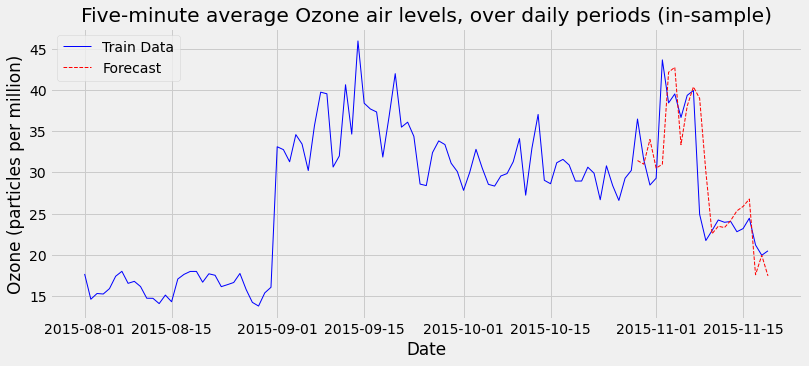

In [75]:
# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Five-minute average Ozone air levels, over daily periods (in-sample)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(air_test_preds.index, air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Ozone (particles per million)")

# legend
plt.legend(loc = "upper left");

Let's see a confidence interval!

We can use `.get_prediction`, in much the same way we used `.get_forecast`

In [76]:
end_date = y.index[-1]

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, dynamice = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

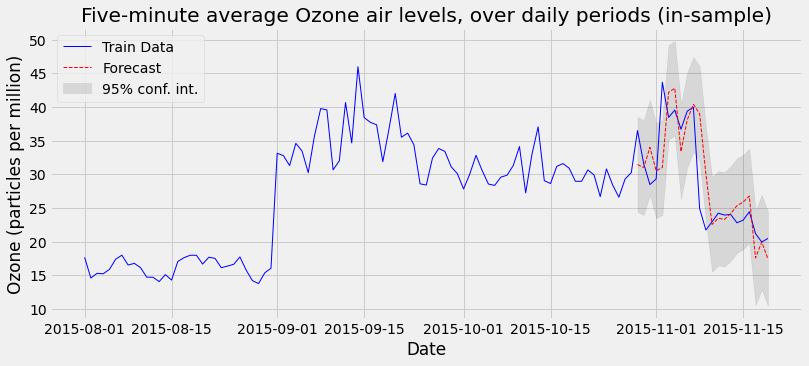

In [77]:
# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Five-minute average Ozone air levels, over daily periods (in-sample)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Ozone (particles per million)")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");


## Model Scoring

In [78]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

0.5476939338521827

In [79]:
# using RMSE, the language of stakeholders
(mean_squared_error(y[start_date:], new_air_test_preds)) ** .5

5.079598411412559

__Interpretation:__ When forecasting Ozone levels (one step ahead), our model is off by about $\pm 5$ parts per million.

### What about making forecasts with SARIMAX?

Our model was training to use exogenous variables, which means we MUST provide them when making predictions and forecasts outside of our training dataset.

In [76]:
# We MUST provide some exogenous variables
# fitted_air_sarimax.forecast(steps = 1)

In [80]:
y.tail(3)

Date
2015-11-17    21.181424
2015-11-18    19.931632
2015-11-19    20.470000
Freq: D, Name: Ozone, dtype: float64

The next date should be 2015-11-19. 

Let's provide the first row of data, just to demonstrate the concept.

___WARNING: When you're making real forecasts, you should be providing the proper exogenous variables!___

In [81]:
# We MUST provide some exogenous variables
fitted_air_sarimax.forecast(steps = 1, exog = X.iloc[0])

2015-11-20    25.437838
Freq: D, dtype: float64

### Ways to solve time-series problems
1. ~~__Keep using a standard model (like linear regression)__ with engineered features related to time~~
2. ~~__Basic ARIMA model__ using ONLY the target variable~~
3. ~~__ARIMAX model__ using the target AND exogenous variables, which can include engineered features related to time~~
4. ~~__SARIMA model__ adding a seasonality component to ARIMA~~
5. ~~__SARIMAX model__ adding a seasonality component to ARIMAX~~
6. __Vector AutoRegressive (VAR) model__ if you need to predict using other predictions as input (akin to transfer learning)

## References
- [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)
- [AIC vs. BIC](https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other)
- [Determine `m`](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#understand-p-d-q-and-m)
- [Determine seasonal period](https://robjhyndman.com/hyndsight/seasonal-periods/)
- [Handling SARIMAX Convergence Warnings](https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax/313811)
- [3 facts about time series forecasting that surprise experienced machine learning practitioners](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387)
- [Forecasting with `auto_arima`](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c)